# Import librerie

In [2]:

import os 
import time
import random
import numpy as np

# plot utilities
import matplotlib as mpl
import matplotlib.pyplot as plt #visualizzazione graph
plt.rcParams['figure.figsize'] = [15,5] # width, height

# image management
import cv2 as cv
from skimage import io, transform, filters, color

#ML KERAS
import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense
from keras.applications import vgg16, mobilenet_v2
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.preprocessing import image as kimage
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam#tensorflow.keras
from tensorflow.keras.utils import plot_model #visualizzare rete

# Crop face (ritaglio visi e metto in cartella destinazione)

In [2]:
# base_path = '/Users/gisto/Desktop/Digital Signal and Image Management/progetto/'
base_path = '/Users/gisto/Desktop/Digital Signal and Image Management/progetto/'

In [77]:
# sorgente (cartella immagini)
images = base_path + 'PROVE_CROP/'

In [78]:
# destinazione (dove mettere facce croppate)
cropped_faces = base_path + 'PROVE_CROP/'

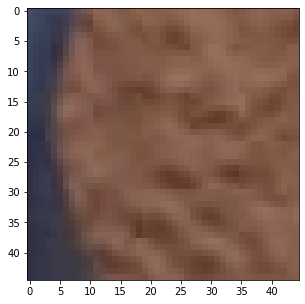

In [79]:
for fi, f in enumerate(sorted(os.listdir(images))):
    try:
        exists = os.path.exists(cropped_faces+f)

        img = cv.imread(images+f )
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_detector.detectMultiScale(img_gray)

        x,y,w,h = faces[0]

        for (x,y,w,h) in faces:
            cropped_image = img[y:y+h, x:x+w]
            plt.imshow(cropped_image[:,:,-1::-1])
            cv.imwrite(cropped_faces+ str(random.randint(0,100))+f, cropped_image)
            
    except:
        print(images+ str(random.randint(0,100))+f + 'didn\'t work')

# Allenamento modello di face recognition

In [12]:
batch_size = 32 #prima era 32
augmentation = False

In [13]:
# funzione di preprocessing delle immagini
#NON USO DATA AUGMENTATION 

if augmentation:
    # con data augmentation
    data_processing = ImageDataGenerator(#preprocessing_function=mobilenet_v2.preprocess_input,
                                         horizontal_flip = True,
                                         width_shift_range = 0.2,
                                         height_shift_range = 0.2,
                                         brightness_range = (0.4,1.5),
                                         zoom_range = [0.5,1.0],
                                         rotation_range = 90)
    
else:
    # senza data augmentation
    train_processing = ImageDataGenerator(#preprocessing_function=mobilenet_v2.preprocess_input, 
                                          validation_split=0.1, rescale=1.0/255.0)
    
test_processing = ImageDataGenerator(#preprocessing_function=mobilenet_v2.preprocess_input, 
                                     rescale=1.0/255.0)

In [14]:
# import immagini
#validation circa il 10% di test

train_generator = train_processing.flow_from_directory(
    directory = base_path + 'TRAIN/',
    target_size = (224, 224),#224 224 
    color_mode = "rgb",
    batch_size = batch_size,#quante immagini raggruppare per ogni iterazione di training
    class_mode = "categorical",
    subset = 'training',
    shuffle = True,#rimescoliamo i dati 
    seed = 1)

validation_generator = train_processing.flow_from_directory(
    directory = base_path + 'TRAIN/',
    target_size = (224, 224),#224 224
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    subset = 'validation',
    shuffle = True,
    seed = 1)

test_generator = test_processing.flow_from_directory(
    directory = base_path + 'TEST',
    target_size = (224, 224),#224 224
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle = False,
    seed = 1)

Found 672 images belonging to 3 classes.
Found 73 images belonging to 3 classes.
Found 83 images belonging to 3 classes.


### Modello

In [15]:
# Modello di base
base_net = mobilenet_v2.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')#224 224
# base_net = vgg16.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

In [16]:
# Congelamento del modello di base
for layer in base_net.layers:
    layer.trainable = False

In [17]:
#aggiungo layer alla retet e faccio diverse prove
x = base_net.output
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
pred = Dense(3, activation='softmax')(x) #softamx per vedere 3 probabilità

net = Model(inputs=base_net.input, outputs=pred)

In [22]:
plot_model(net,show_layer_names=False, show_shapes=True) #da usare con collab ----> no jupyter(problemi vari)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [38]:
net.compile(loss=categorical_crossentropy,
            optimizer=Adam(0.0001), # learning rate più lento
            metrics=['accuracy'])

In [39]:
#early stopping su accuracy se non aumenta
epochs = 30

early_stopping = EarlyStopping(monitor='val_accuracy', verbose = 1, patience = 3, 
                               mode = 'max', restore_best_weights = True)

history = net.fit(train_generator, 
                  epochs = epochs,
                  validation_data = validation_generator,
                  callbacks = [early_stopping])

Epoch 1/30
21/21 [==============================] - 17s 633ms/step - loss: 1.0430 - accuracy: 0.4613 - val_loss: 0.7439 - val_accuracy: 0.8219
Epoch 2/30
21/21 [==============================] - 13s 592ms/step - loss: 0.7497 - accuracy: 0.7188 - val_loss: 0.5505 - val_accuracy: 0.8356
Epoch 3/30
21/21 [==============================] - 12s 589ms/step - loss: 0.5932 - accuracy: 0.8110 - val_loss: 0.4376 - val_accuracy: 0.8630
Epoch 4/30
21/21 [==============================] - 12s 584ms/step - loss: 0.4605 - accuracy: 0.8557 - val_loss: 0.3574 - val_accuracy: 0.9041
Epoch 5/30
21/21 [==============================] - 12s 554ms/step - loss: 0.3838 - accuracy: 0.8750 - val_loss: 0.2940 - val_accuracy: 0.9178
Epoch 6/30
21/21 [==============================] - 12s 563ms/step - loss: 0.3404 - accuracy: 0.8914 - val_loss: 0.2527 - val_accuracy: 0.9315
Epoch 7/30
21/21 [==============================] - 12s 569ms/step - loss: 0.2836 - accuracy: 0.9182 - val_loss: 0.2118 - val_accuracy: 0.9178

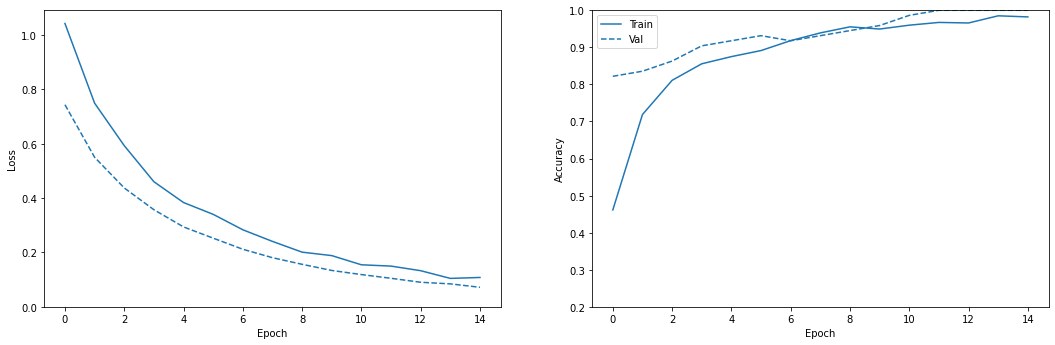

In [40]:
#funzione per vedere metriche modello 
mpl.rcParams['figure.figsize'] = (18, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics =  ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'accuracy':
            plt.ylim([0.2,1])
        else:
            plt.ylim([0,1])

    plt.legend()


plot_metrics(history)

### report

In [41]:
#report modello
from sklearn.metrics import classification_report

In [42]:
performance = net.evaluate(test_generator)

3/3 [==============================] - 2s 408ms/step - loss: 0.0715 - accuracy: 1.0000


In [43]:
true_labels=test_generator.classes
predictions=net.predict(test_generator)

In [44]:
predictions=np.array([np.argmax(x) for x in predictions])

In [45]:
print(classification_report(true_labels,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00        28

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83



In [46]:
# Save model
net.save("model_mobilenetv2.h5")

C:\Users\gisto\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Test modello

In [3]:
net = keras.models.load_model('model_mobilenetv2.h5')

In [26]:
#foto loro riccardo4.jpg , leo2.jpg
names = ['Leonardo' ,'Riccardo', 'Giacomo']

tipo = 'take'
filename = 'leo2.jpg'

In [27]:
#differenza visualizzazione se foto scattata o importata 
if tipo == 'take':
    cap = cv.VideoCapture(0)
    result, img = cap.read() # Acquisizione immagine
    cap.release() # Rilascio del dispositivo
    img = img[:,:,-1::-1] # scambio canali

elif tipo == 'import':
    img = io.imread(filename)

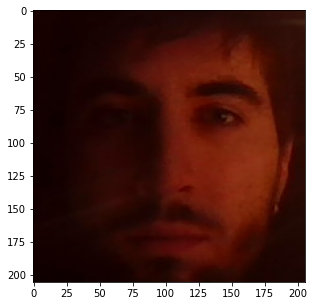

In [28]:
# Caricamento modello per il rilevamento di volti frontali
face_detector = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

faces = face_detector.detectMultiScale(img)
#faces = faces.tolist()

for (x,y,w,h) in faces:
    face = img[y:y+h, x:x+w,]

plt.imshow(face)

In [29]:
# preprocessing immagine
img_pixels = cv.resize(face/255, (224, 224))#rifaccio il rescale a 255 
img_pixels = img_to_array(img_pixels)
img_pixels = np.expand_dims(img_pixels, axis = 0)

In [30]:
# recognition
y_pred = net.predict(img_pixels)
print(y_pred)
print(names[np.argmax(y_pred)])

[[0.02867269 0.1330804  0.83824694]]
Giacomo
